<a href="https://colab.research.google.com/github/Manvi0509/Manvi0509.github.io/blob/main/VAR%2Bqr%2Baqi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 1/80


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 142.7071 - val_loss: 23.9265
Epoch 2/80
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 25.6201 - val_loss: 21.4471
Epoch 3/80
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 19.2873 - val_loss: 9.4216
Epoch 4/80
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9.3952 - val_loss: 8.0535
Epoch 5/80
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 8.9221 - val_loss: 8.0426
Epoch 6/80
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.0997 - val_loss: 8.4906
Epoch 7/80
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 8.2599 - val_loss: 8.0016
Epoch 8/80
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.2970 - val_loss: 8.2780
Epoch 9/80
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.3640 - val_loss: 7.9650
Epoch 10/80
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.7347 - val_loss: 8.1560
Epoch 11/80
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.0673 - val_loss: 8.6191
Epoch 12/80
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.2495 - val_loss: 

<ipython-input-1-d426460431b8>:101: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_actual = comparison['Actual'].resample('M').apply(lambda x: calculate_var(x, quantile=0.85))
<ipython-input-1-d426460431b8>:102: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_predicted = comparison['Predicted'].resample('M').apply(lambda x: calculate_var(x, quantile=0.85))


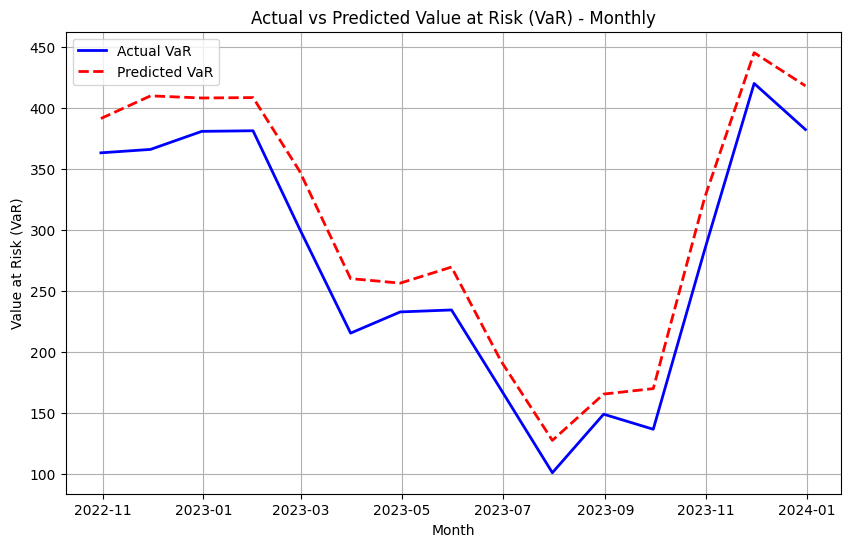

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow.keras.backend as K
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Load your AQI data
data = pd.read_excel(r"/content/DELHI_AQI.xlsx")
data['Timestamp'] = pd.to_datetime(data['Timestamp'])
data.set_index('Timestamp', inplace=True)

# Remove leading/trailing spaces from column names
data.columns = data.columns.str.strip()

# Define the columns for which you want to create lag features
columns = ['Max temp', 'Min temp', 'precip', 'windspeed', 'winddir',
           'PM2.5', 'PM10', 'NO2', 'SO2', 'Max 8-h CO', 'Max 8-h Ozone', 'AQI']

# Check which columns exist in the dataset
existing_columns = [col for col in columns if col in data.columns]

# Generate 1 lag for each available column (including original)
lags = 1
for col in existing_columns:
    # Create lagged feature
    data[f'{col}lag{lags}'] = data[col].shift(lags)

# Drop rows with NaN values (from lagged features)
data = data.dropna()

# Define predictors (both original and lagged features)
predictors = [f'{col}lag{lags}' for col in existing_columns]

# Define the training and testing data (80-20 split)
train_size = int(0.8 * len(data))
train_data = data[:train_size]
test_data = data[train_size:]

X_train = train_data[predictors]
y_train = train_data['AQI']
X_test = test_data[predictors]
y_test = test_data['AQI']

# Scale data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Reshape for GRU (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Define the custom Quantile Loss function
def quantile_loss(y_true, y_pred, quantile=0.85):
    error = y_true - y_pred
    loss = K.mean(K.maximum(quantile * error, (quantile - 1) * error), axis=-1)
    return loss

# Define GRU model
model = Sequential([
    GRU(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False),
    Dense(32, activation='relu'),
    Dense(1)  # Output one value per input sample
])

# Compile the model with the Quantile Loss
model.compile(optimizer=Adam(learning_rate=0.01), loss=lambda y_true, y_pred: quantile_loss(y_true, y_pred, quantile=0.85))

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
model.fit(X_train, y_train, epochs=80, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Predict on test data
predictions = model.predict(X_test).flatten()

# Compare actual vs predicted values
comparison = pd.DataFrame({'Actual': y_test, 'Predicted': predictions.flatten()})

# Calculate error metrics
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

# Print evaluation metrics
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'R-squared: {r2}')

# Function to calculate Value at Risk (VaR)
def calculate_var(data, quantile=0.85):
    return data.quantile(quantile)

# Resample the data to monthly frequency (for Actual and Predicted values)
monthly_actual = comparison['Actual'].resample('M').apply(lambda x: calculate_var(x, quantile=0.85))
monthly_predicted = comparison['Predicted'].resample('M').apply(lambda x: calculate_var(x, quantile=0.85))

# Plot Actual vs Predicted VaR for each month
plt.figure(figsize=(10, 6))
plt.plot(monthly_actual.index, monthly_actual, label='Actual VaR', color='blue', linestyle='-', linewidth=2)
plt.plot(monthly_predicted.index, monthly_predicted, label='Predicted VaR', color='red', linestyle='--', linewidth=2)
plt.xlabel('Month')
plt.ylabel('Value at Risk (VaR)')
plt.title('Actual vs Predicted Value at Risk (VaR) - Monthly')
plt.legend()
plt.grid(True)
plt.show()
